<a href="https://colab.research.google.com/github/Vrittigyl/stock-prediction/blob/main/Stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Stock Price Prediction using Numerical Trends and News Sentiment
A machine learning project to predict stock price trends (up/down) using historical stock data and sentiment analysis of financial news headlines.

Features:-
- Predicts stock price trends using historical data and news sentiment.
- Integrates LSTM and ARIMA models for time-series forecasting.
- Uses NLP to analyze sentiment from financial news via the NewsAPI.
- Combines technical analysis with sentiment scores for improved accuracy.



In [ ]:
!pip install -r requirements.txt

#Sentiment Analysis

##Dataset



In [ ]:
from newsapi import NewsApiClient
import pandas as pd
from datetime import datetime

newsapi = NewsApiClient(api_key='b4f8ba43db3d416c942e6f26984d3262')

# Fetch news
all_articles = newsapi.get_everything(q='GOOG', language='en', sort_by='relevancy')

headlines = [article['title'] for article in all_articles['articles']]
dates = [article['publishedAt'] for article in all_articles['articles']]
dates = [datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ').date() for date in dates]

# Convert dates to pandas datetime format
dates = pd.to_datetime(dates)
print("These are the headlines")
print(headlines[:5])
print(dates[:5])

these are all the articles
{'status': 'ok', 'totalResults': 129, 'articles': [{'source': {'id': None, 'name': 'Yahoo Entertainment'}, 'author': 'Madison Mills', 'title': 'Why Google could help Alphabet win the AI race', 'description': "Alphabet's (GOOG, GOOGL) Google artificial intelligence (AI) roll-out has raised questions about its competitive edge. Joe Kaiser, Mercato Partners CEO...", 'url': 'https://finance.yahoo.com/video/why-google-could-help-alphabet-103056465.html', 'urlToImage': 'https://s.yimg.com/ny/api/res/1.2/.we2MdtmcN.FYPRSa3zn.A--/YXBwaWQ9aGlnaGxhbmRlcjt3PTEyMDA7aD02NzY-/https://s.yimg.com/os/creatr-uploaded-images/2025-05/aa16e580-3656-11f0-bded-cf50632d581f', 'publishedAt': '2025-05-22T10:30:56Z', 'content': 'I want to get your take on on Google here. It seems to me that they still do need to convince investors that they can win this AI race. Do you think that they are positioned to do that? \r\nI do. I thi… [+2511 chars]'}, {'source': {'id': None, 'name': 'Yahoo En

##Data Preprocessing



In [ ]:
from transformers import pipeline
import re
import nltk
from nltk.corpus import stopwords
from transformers import pipeline

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to process headlines
def process_headline(text):

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


processed_headlines = [process_headline(headline) for headline in headlines]
print(processed_headlines[:5])

['google could help alphabet win ai race', 'alphabet goog fell along peers', 'alphabet buy best ai play reasonable valuation', 'two prominent investors bearish alphabet inc goog stock', 'keybanc keeps overweight rating alphabet inc goog']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Model Training

In [ ]:
from datasets import load_dataset,Dataset
import pandas as pd

dataset=pd.read_csv("/content/drive/MyDrive/all-data.csv")

dataset = Dataset.from_pandas(dataset)


label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
dataset = dataset.map(lambda x: {"Label": label_mapping[x["Label"]]})

# 80% train and 20% validation
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset["train"]
validation_dataset = dataset["test"]

Map:   0%|          | 0/4845 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer,DefaultDataCollator

tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def tokenize(batch):
    return tokenizer(batch["Headlinesexample"], padding="max_length", truncation=True,max_length=64)

train_dataset = train_dataset.map(tokenize, batched=True)
validation_dataset = validation_dataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/969 [00:00<?, ? examples/s]

In [ ]:
# Set up data collator to batch the input correctly
data_collator = DefaultDataCollator(return_tensors="tf")

train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="Label",
    shuffle=True,
    batch_size=4,
)

validation_dataset = validation_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="Label",
    shuffle=False,
    batch_size=4,
)
# Verify dataset type
print(f"Training dataset type: {type(train_dataset)}")
print(f"Validation dataset type: {type(validation_dataset)}")


Training dataset type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Validation dataset type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)

tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
#a tf model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=1
)

969/969 [==============================] - 4511s 5s/step - loss: 0.6817 - sparse_categorical_accuracy: 0.7650 - val_loss: 0.3557 - val_sparse_categorical_accuracy: 0.8596


In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
model.save_pretrained("/content/my_tf_model")
tokenizer.save_pretrained("/content/my_tf_model")
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/my_tf_model /content/drive/MyDrive/

243/243 [==============================] - 244s 1s/step - loss: 0.3557 - sparse_categorical_accuracy: 0.8596
Validation Loss: 0.35568270087242126
Validation Accuracy: 0.859649121761322
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the model path

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model = TFAutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/my_tf_model")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/my_tf_model")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/my_tf_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


##Output of SA

In [ ]:
from transformers import pipeline
# Load pre-trained FinBERT model for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Analyze sentiment of the processed headlines
sentiment_scores = sentiment_analyzer(processed_headlines)

# Display sentiment of each headline
for original, processed, sentiment in zip(headlines[:7], processed_headlines[:7], sentiment_scores[:7]):
    print(f"Original Headline: {original}")
    print(f"Processed Headline: {processed}")
    print(f"Sentiment: {sentiment}")
    print('-' * 80)

# Convert sentiment scores to a format we can use
# Example mapping: positive -> 1, neutral -> 0, negative -> -1
sentiment_labels = [1 if s['label'] == 'positive' else -1 if s['label'] == 'negative' else 0 for s in sentiment_scores]

#sentiment_scores_values = [s['score'] for s in sentiment_scores]
sentiment_df = pd.DataFrame({'Date': dates, 'Sentiment': sentiment_labels})
sentiment_df = sentiment_df.groupby('Date').mean().reset_index()

# Display the first few rows of the sentiment DataFrame
print(sentiment_df.head())


Device set to use 0


Original Headline: Why Google could help Alphabet win the AI race
Processed Headline: google could help alphabet win ai race
Sentiment: {'label': 'Positive', 'score': 0.7182533144950867}
--------------------------------------------------------------------------------
Original Headline: Alphabet (GOOG) Fell Along with Peers
Processed Headline: alphabet goog fell along peers
Sentiment: {'label': 'Positive', 'score': 0.8335282206535339}
--------------------------------------------------------------------------------
Original Headline: Alphabet: Buy More The Best AI Play At A Reasonable Valuation
Processed Headline: alphabet buy best ai play reasonable valuation
Sentiment: {'label': 'Positive', 'score': 0.7350632548332214}
--------------------------------------------------------------------------------
Original Headline: Two Prominent Investors Are Bearish on Alphabet Inc. (GOOG) Stock
Processed Headline: two prominent investors bearish alphabet inc goog stock
Sentiment: {'label': 'Positiv

#Technical Analysis

##Dataset

In [ ]:
import yfinance as yf

# Fetch historical stock data
ticker = 'GOOG'
stock_data = yf.download(ticker, start='2025-4-30', end='2025-5-30', interval='1d')

# Prepare data for technical analysis (use 'Close' prices)
stock_prices_df = stock_data[['Close']].dropna()  # Keep only 'Close' prices and remove any missing values

# Convert 'Close' prices to a DataFrame with columns ['Date', 'Price']
stock_prices_df.reset_index(inplace=True)
stock_prices_df.rename(columns={'Close': 'Price'}, inplace=True)  # Rename 'Close' to 'Price'
# Display the result
print(stock_prices_df.tail())

[*********************100%***********************]  1 of 1 completed

Price        Date       Price
Ticker                   GOOG
16     2025-05-08  155.750000
17     2025-05-09  154.380005
18     2025-05-12  159.580002
19     2025-05-13  160.889999
20     2025-05-14  166.809998


##Model Training

In [ ]:
from pmdarima import auto_arima

# Fit ARIMA model on stock prices
arima_model = auto_arima(stock_prices_df['Price'], seasonal=False, trace=True, suppress_warnings=True)

# Predict next day's stock price
n_days = 1
arima_forecast = arima_model.predict(n_periods=n_days)

print(f"ARIMA Prediction for next day: {arima_forecast}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=131.436, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=274.644, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=130.852, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=131.358, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=129.693, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=131.847, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=131.521, Time=1.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=133.421, Time=1.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=121.629, Time=0.58 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=119.660, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=117.764, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=124.239, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=119.547, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=122.158, Time=0.07 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 5.669 seconds
ARIMA Prediction for next day: 21    165.906946
dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#Merging outputs of both models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming `stock_prices_df` is a DataFrame with columns ['Date', 'Price'] and `sentiment_df` has columns ['Date', 'Sentiment']
# Ensure both Date columns are in the same format (convert to naive datetime or to UTC)
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date']).dt.tz_localize(None)  # Remove timezone info (naive datetime)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.tz_localize(None)  # Remove timezone info (naive datetime)
#convert multiindex stock_prices to unindex
stock_prices_df.columns = ['_'.join(filter(None, col)).strip() for col in stock_prices_df.columns.values]
stock_prices_df.rename(columns={'Date': 'Date', 'Price_GOOG': 'Price'}, inplace=True)
# Merge stock prices and sentiment data based on the 'Date' column
merged_data = pd.merge(stock_prices_df, sentiment_df, on='Date')

# Check the date ranges in both DataFrames
print(f"Stock Prices Date Range: {stock_prices_df['Date'].min()} to {stock_prices_df['Date'].max()}")
print(f"Sentiment Data Date Range: {sentiment_df['Date'].min()} to {sentiment_df['Date'].max()}")

# Check the number of matching rows after the merge
merged_data = pd.merge(stock_prices_df, sentiment_df, on='Date', how='inner')
print(f"Number of matching rows after merge: {len(merged_data)}")

# Scale the stock prices
scaler = MinMaxScaler(feature_range=(0, 1))
merged_data['Scaled_Price'] = scaler.fit_transform(merged_data['Price'].values.reshape(-1, 1))

# Create a dataset with both scaled stock prices and sentiment data
def create_dataset_with_sentiment(merged_data, time_step=60):
    X, y = [], []
    stock_data = merged_data['Scaled_Price'].values
    sentiment_data = merged_data['Sentiment'].values

    for i in range(len(stock_data) - time_step - 1):
        stock_window = stock_data[i:(i + time_step)]  # Past stock prices
        sentiment_window = sentiment_data[i:(i + time_step)]  # Sentiment during the same period

        combined = np.column_stack((stock_window, sentiment_window))  # Combine stock prices and sentiment as 2D features
        X.append(combined)
        y.append(stock_data[i + time_step])  # Next stock price as the target

    return np.array(X), np.array(y)

# Set the time step for prediction
time_step = 6

# Create the datasets with stock prices and sentiment
X, y = create_dataset_with_sentiment(merged_data, time_step)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], time_step, 2)  # 2 features: stock prices and sentiment

# X and y are now ready for LSTM training



Stock Prices Date Range: 2025-04-15 00:00:00 to 2025-05-14 00:00:00
Sentiment Data Date Range: 2025-04-30 00:00:00 to 2025-05-30 00:00:00
Number of matching rows after merge: 11


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm_model(time_step):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 2)))  # 2 features: stock prices and sentiment
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Output layer (predicting next stock price)

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the model
model = build_lstm_model(time_step)
model.fit(X, y, epochs=20, batch_size=60)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1479
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1214
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0990
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0806
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0662
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0562
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0510
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0508
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0543
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0588
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0613
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0611
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0588
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0557
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0526
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/st

In [ ]:
def predict_future_prices(model, merged_data, time_step, future_days):
    # Get the last 'time_step' days of stock prices and sentiment data
    recent_stock_prices = merged_data['Scaled_Price'].values[-time_step:]
    recent_sentiment = merged_data['Sentiment'].values[-time_step:]

    # Combine them into a single input array
    recent_data = np.column_stack((recent_stock_prices, recent_sentiment)).reshape(1, time_step, 2)

    # Predict future prices day by day
    future_predictions = []

    for _ in range(future_days):
        # Predict the next stock price
        next_price = model.predict(recent_data)
        future_predictions.append(next_price[0][0])

        # Prepare the new data point for the next prediction
        next_data = np.array([[next_price[0][0], recent_sentiment[-1]]])  # Assuming sentiment remains constant

        # Shift window by 1 and add new data
        recent_data = np.concatenate((recent_data[:, 1:, :], next_data.reshape(1, 1, 2)), axis=1)

    return future_predictions

# Predict stock prices for the next 10 days
future_days = 20
predicted_future_prices = predict_future_prices(model, merged_data, time_step, future_days)

# Show predicted stock prices (in scaled format)
print(predicted_future_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.21879977, 0.2452466, 0.2556467, 0.26606694, 0.2557335, 0.23936905, 0.20231974, 0.20291299, 0.2014662, 0.19902486, 0.19579625, 0.19292392, 0.19076294, 0.19031532, 0.18975152, 0.18920392, 0.18874165, 0.18841434, 0.18820983, 0.18809643]


#Output

In [ ]:
# Inverse transform the predicted prices
predicted_future_prices = scaler.inverse_transform(np.array(predicted_future_prices).reshape(-1, 1))

# Display the final predicted stock prices
print("Predicted stock prices for the next 10 days:")
for i, price in enumerate(predicted_future_prices, 1):
    print(f"Day {i}: {price[0]:.2f}")

Predicted stock prices for the next 10 days:
Day 1: 155.87
Day 2: 156.24
Day 3: 156.38
Day 4: 156.53
Day 5: 156.38
Day 6: 156.15
Day 7: 155.63
Day 8: 155.64
Day 9: 155.62
Day 10: 155.59
Day 11: 155.54
Day 12: 155.50
Day 13: 155.47
Day 14: 155.47
Day 15: 155.46
Day 16: 155.45
Day 17: 155.44
Day 18: 155.44
Day 19: 155.44
Day 20: 155.44


the prices after Date     2025-05-14 00:00:00
Price             166.809998
dtype: object


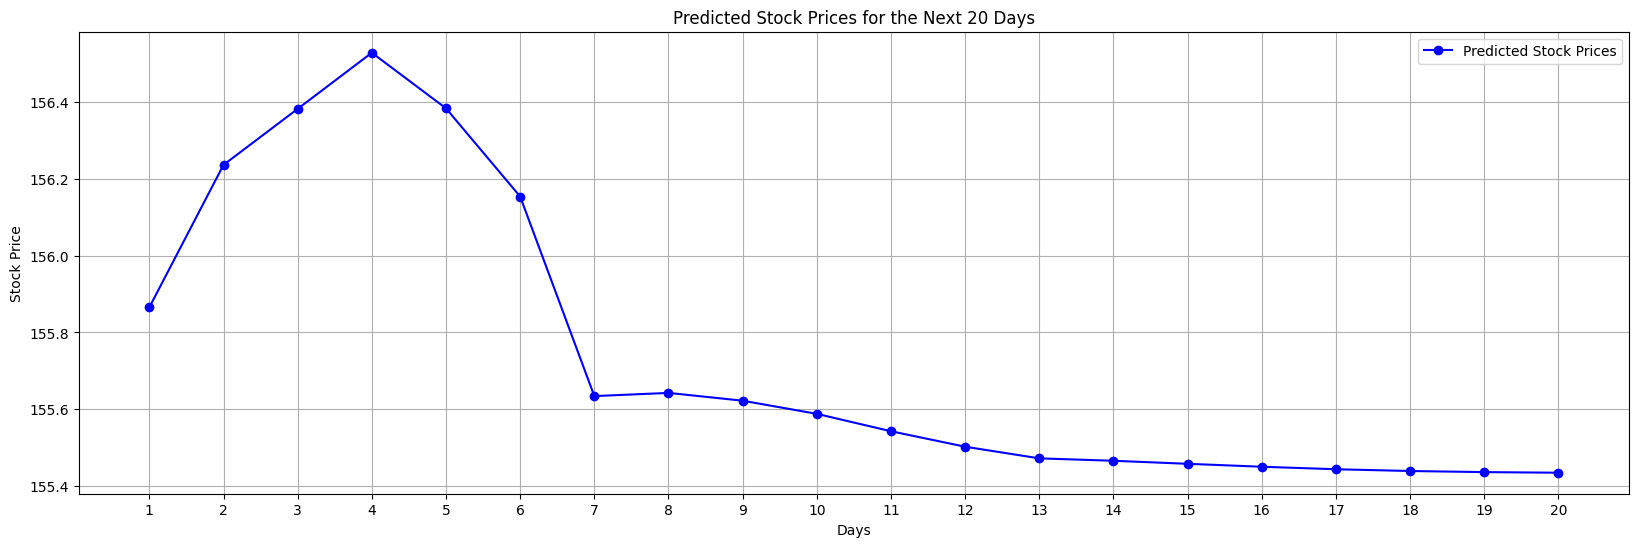

In [ ]:
import matplotlib.pyplot as plt
# Prepare data for plotting
days = range(1, 21)  # Days from 1 to 10
print(f"the prices after {stock_prices_df.max()}")
# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(days, predicted_future_prices, marker='o', linestyle='-', color='b', label='Predicted Stock Prices')
plt.title('Predicted Stock Prices for the Next 20 Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.xticks(days)  # Show x-ticks for each day
plt.grid()
plt.legend()
plt.show()